In [100]:
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv
import re #regular expression
import string
import itertools as it
from itertools import islice
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier
import warnings
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment import SentimentAnalyzer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import emoji
#nltk.download('brown')
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing

In [61]:
df= pd.read_csv("/Users/pritigirishvankudre/Day9_Hackathon2/Twitter Sentiment/train.csv")
df.count()

tweet_id     7274
tweet        7273
sentiment    7274
dtype: int64

In [62]:
df.dropna(inplace=True)
df.count()

tweet_id     7273
tweet        7273
sentiment    7273
dtype: int64

In [63]:
dfRetweets = df[df['tweet'].str.contains(' RT ') == True]
dfRetweets.count()

tweet_id     699
tweet        699
sentiment    699
dtype: int64

Roughly <10% retweets so not removing them ; also lot of RTs in test data so cannot be ignored

In [64]:
dfWithoutRetweets = df[df['tweet'].str.contains(' RT ') == False]
dfWithoutRetweets.count()

tweet_id     6574
tweet        6574
sentiment    6574
dtype: int64

# visualize distribution of sentiments

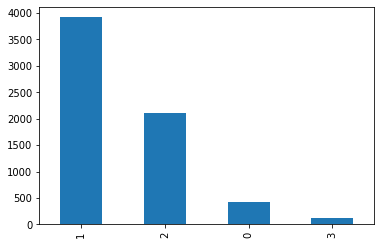

In [65]:
dfWithoutRetweets['sentiment'].value_counts().plot(kind='bar')
plt.show()

# TEXT PREPROCESSING FUNCTIONS

In [66]:
str7="RT @mention apple MicroSoft Google Hey #SXSW how 1231 httpsfsd :-)  #iPad to Japan. Do you think so"

def getCapitalizedWords(string1):
    words=string1.split()
    capwords=[word for word in words if word[0].isupper()]
    return capwords

x=getCapitalizedWords(str7)
print(x)

['RT', 'MicroSoft', 'Google', 'Hey', 'Japan.', 'Do']


In [67]:
str7="RT @#dfjasf #123123 apple MicroSoft Google Hey #SXSW how 1231 httpsfsd :-)  #iPad to Japan. Do you think so"

def hashtag_extract(tweet):
    hashtags = []
    # Loop over the words in the tweet
    x=tweet.split()
    for i in x:
        if re.match(r'^#', i):
            hashtags.append(i)
    
    return hashtags
    
x=hashtag_extract(str7)
print(x)

['#123123', '#SXSW', '#iPad']


In [68]:
str7="RT @#dfjasf #123123 apple MicroSoft Google Hey #SXSW how 1231 httpsfsd :-)  #iPad to Japan. Do you think so"

def user_extract(tweet):
    userhandles = []
    # Loop over the words in the tweet
    x=tweet.split()
    for i in x:
        if re.match(r'^@', i):
            userhandles.append(i)
    return userhandles

x=user_extract(str7)
print(x)

['@#dfjasf']


In [69]:
def remove_HTTP(tweet):
        
    # remove hyperlinks
    tweet = re.sub(r'http\S+', '', tweet)
    return tweet

str7="RT @mention Hey #SXSW how 1231 httpsfsd :-) :D http://www.hotmail.com this $ your spending #iPad to Japan. Do you REALLY need that thing?"
print(remove_HTTP(str7))

RT @mention Hey #SXSW how 1231  :-) :D  this $ your spending #iPad to Japan. Do you REALLY need that thing?


In [70]:
#remove non-alphabetic characters
String1="Tsdfsaf RT @ramesh {$95%}&quot; &lt; &gt; &amp; Austin Ã¥Ã‡ Details {link} \
        #testing 12:00-3:59:59p 03/13/11 abcd ;-13123 14 123 ^cdsdc , :-) :-( ) &quot;>"

def remove_junk(s1):
    s2 = re.sub("[^a-zA-Z#@]"," ", s1)
    return s2

x=remove_junk(String1)
print(x)


Tsdfsaf RT @ramesh        quot   lt   gt   amp  Austin      Details  link          #testing              p          abcd                 cdsdc              quot  


In [71]:
String11="Tsfsa12 @fsfksd #sfsfdjkj there was a little boy cat dog apple !@#!#%%^&^&123 https://www.rediff.com :D :-) :-( !!! "

def basic_cleanup(s1):
    s2=remove_HTTP(s1)
    s3=remove_junk(s2)
    s4 = re.sub(r'@\S+',"", s3)# removed user handles as they have already been captured
    s5 = re.sub(r'#\S+',"", s4)# removed hashtags as they have already been handled
    return s5

x=basic_cleanup(String11)
print(x)

Tsfsa     there was a little boy cat dog apple   #            D             


In [72]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.extend(['I','yr', 'free', 'lol', 'rotfl', 'yolo','brb','link','quot','amp'])

def remove_stopwords(text):
    t2=text.split()
    text2 = " ".join(word for word in t2 if word not in stopwords)
    return text2
 
str="I i am Am twenty big judicious lol cat lion dog @hello #junk"
x=remove_stopwords(str)
print(x)

Am twenty big judicious cat lion dog @hello #junk


In [73]:
#remove non-alphabetic characters
String1="Tsdfsaf A C abc an the if there where to acbsd RT @ramesh {$95%}&quot; &lt; &gt; &amp; Austin Ã¥Ã‡ Details {link} \
        #testing 12:00-3:59:59p 03/13/11 abcd ;-13123 14 123 ^cdsdc , :-) :-( ) &quot;>"

def do_smart_word_tokenize(text):
    wordslist=word_tokenize(text.lower())
    
    #remove 1 and 2 letter words 
    wordslist2= ' '.join(word for word in wordslist if len(word)>2)
    
    #remove stopwords
    wordslist3=remove_stopwords(wordslist2)
    
    return wordslist3

x=do_smart_word_tokenize(String1)
print(x)

tsdfsaf abc acbsd ramesh austin ã¥ã‡ details testing 12:00-3:59:59p 03/13/11 abcd -13123 123 ^cdsdc


In [74]:
wordtokens=["Business","officially","mentioned","twenty","awesome","feline","cats","dogs","unusually","faithfully","cruelly","wonderful"]

def get_stem_words(list1):
    
    stemmer = SnowballStemmer("english")
    stem_words=[stemmer.stem(word) for word in list1]
    stem_words=" ".join(word for word in stem_words)
    return stem_words

x=get_stem_words(wordtokens)
print(x)

busi offici mention twenti awesom felin cat dog unusu faith cruelli wonder


In [75]:
wordtokens=["Business","officials","officially","offices","awesome","feline","cats","dogs","unusually","faithfully","cruelly","wonderful"]

def get_lemma_words(list1):
    
    lemmatizer=WordNetLemmatizer()
    lemm_words=[lemmatizer.lemmatize(word) for word in list1]
    lemm_words="".join(word for word in lemm_words)
    return lemm_words

#x=get_lemma_words(df["Tweet_Word_tokens"])
#print(x)

In [76]:
String1="Hi Hello @sdfasf #cool #hot 1$%&* hello hi great sky sky earth water water everywhere billions of i an the there blistering barnacles great sky"

def getTweetLength(tweet):
    return len(tweet)

x=getTweetLength(String1)
print(x)

143


In [77]:
def generate_WordCloud(df_tweet,filename):
    text = " ".join(tweet for tweet in df_tweet)
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    wordcloud.to_file(filename)
    plt.show()
    
#generate_WordCloud(df["tweet"],"sample.png")

In [80]:
String9="There was a beautiful cat and big dog in the grey mountains near the Indian ocean"
def get_NounPhrases(text):
    tb=TextBlob(text)
    np=tb.noun_phrases
    return np

x=get_NounPhrases(String9)
print(x)

['beautiful cat', 'big dog', 'grey mountains', 'indian ocean']


In [81]:
def get_NounList(text):
    tb=TextBlob(text)
    nounlist=[]
    for word,pos in tb.tags:
        if pos == 'NN':
            nounlist.append(word)
    nounlist=" ".join(word for word in nounlist)
    return nounlist
    
        
x=get_NounList(String9)
print(x)

cat dog grey ocean


In [120]:
def get_AdjList(text):
    tb=TextBlob(text)
    adjlist=[]
    for word,pos in tb.tags:
        if pos == 'JJ':
            adjlist.append(word)
    adjlist=" ".join(word for word in adjlist)
    return adjlist
    
        
x=get_AdjList(String9)
print(x)

beautiful big Indian


In [82]:
def get_bigrams(text):
    tb=TextBlob(text)
    raw_bigrams=tb.ngrams(n=2)
    return raw_bigrams

x=get_bigrams(String9)
print(x)

[WordList(['There', 'was']), WordList(['was', 'a']), WordList(['a', 'beautiful']), WordList(['beautiful', 'cat']), WordList(['cat', 'and']), WordList(['and', 'big']), WordList(['big', 'dog']), WordList(['dog', 'in']), WordList(['in', 'the']), WordList(['the', 'grey']), WordList(['grey', 'mountains']), WordList(['mountains', 'near']), WordList(['near', 'the']), WordList(['the', 'Indian']), WordList(['Indian', 'ocean'])]


In [83]:
def get_trigrams(text):
    tb=TextBlob(text)
    raw_trigrams=tb.ngrams(n=3)
    return raw_trigrams

x=get_trigrams(String9)
print(x)

[WordList(['There', 'was', 'a']), WordList(['was', 'a', 'beautiful']), WordList(['a', 'beautiful', 'cat']), WordList(['beautiful', 'cat', 'and']), WordList(['cat', 'and', 'big']), WordList(['and', 'big', 'dog']), WordList(['big', 'dog', 'in']), WordList(['dog', 'in', 'the']), WordList(['in', 'the', 'grey']), WordList(['the', 'grey', 'mountains']), WordList(['grey', 'mountains', 'near']), WordList(['mountains', 'near', 'the']), WordList(['near', 'the', 'Indian']), WordList(['the', 'Indian', 'ocean'])]


In [84]:
def get_Polarity(text):
    tb=TextBlob(text)
    polarity=tb.sentiment.polarity
    return polarity

x=get_Polarity(String9)
print(x)

0.22499999999999998


In [85]:
def get_Subjectivity(text):
    tb=TextBlob(text)
    subjectivity=tb.sentiment.subjectivity
    return subjectivity

x=get_Subjectivity(String9)
print(x)

0.4


In [86]:
def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""
    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list

def get_top_k_predictions(model,X_test,k):
    
    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]
    
    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]
    
    preds=[ item[::-1] for item in preds]
    
    return preds
   

def compute_accuracy(eval_items:list):
    correct=0
    total=0
    
    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])
        
        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break
       
    accuracy=correct/float(len(eval_items))
    return accuracy

def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""
    
    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]
        
        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0
    
    for item in items:   
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def extract_features(field,modelflag):
    
    print("Extracting features using : ",modelflag)
    print("Field is : ",field)
    print("training data size : ",training_data.shape)
    print("testing data size : ",testing_data.shape)
    
    if("TFIDF") in modelflag:
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)

        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)
        return train_feature_set,test_feature_set,tfidf_vectorizer

    else:
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)

        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)    
        return train_feature_set,test_feature_set,cv

# FEATURE ENGINEERING SECTION 

In [87]:
df['Hashtags'] = df['tweet'].apply(lambda x: hashtag_extract(x))
df['Tweet_basic_cleaned'] = df['tweet'].apply(lambda x: basic_cleanup(x))
df['Tweet_Word_tokens']=df['Tweet_basic_cleaned'].apply(lambda x: do_smart_word_tokenize(x))
df['Tweet_len']=df['Tweet_Word_tokens'].apply(lambda x: getTweetLength(x))
df['Lemmas']=df['Tweet_Word_tokens'].apply(lambda x: get_lemma_words(x))
df['Polarity']=df['Tweet_basic_cleaned'].apply(lambda x: get_Polarity(x))
df['Subjectivity']=df['Tweet_basic_cleaned'].apply(lambda x: get_Subjectivity(x))
df['Nouns']=df['Tweet_basic_cleaned'].apply(lambda x: get_NounList(x))
df['NounPhrases']=df['Tweet_basic_cleaned'].apply(lambda x: get_NounPhrases(x))
df['Bigrams']=df['Tweet_basic_cleaned'].apply(lambda x: get_bigrams(x))
df['Trigrams']=df['Tweet_basic_cleaned'].apply(lambda x: get_trigrams(x))
df['Userhandles'] = df['tweet'].apply(lambda x: user_extract(x))


df.head(20)

,tweet_id,tweet,sentiment,Hashtags,Tweet_basic_cleaned,Tweet_Word_tokens,Tweet_len,Lemmas,Polarity,Subjectivity,Nouns,NounPhrases,Bigrams,Trigrams,Userhandles
0,1701,#sxswnui #sxsw #apple defining language of tou...,1,"[#sxswnui, #sxsw, #apple]",defining language of touch with different d...,defining language touch different dialects bec...,59,defining language touch different dialects bec...,0.150000,0.650000,language,[different dialects],"[[defining, language], [language, of], [of, to...","[[defining, language, of], [language, of, touc...",[]
1,1851,Learning ab Google doodles! All doodles should...,1,"[#GoogleDoodle, #sxsw]",Learning ab Google doodles All doodles should...,learning google doodles doodles light funny in...,87,learning google doodles doodles light funny in...,0.381250,0.893750,,"[learning, google, light funny amp innovative,...","[[Learning, ab], [ab, Google], [Google, doodle...","[[Learning, ab, Google], [ab, Google, doodles]...",[]
2,2689,one of the most in-your-face ex. of stealing t...,2,"[#SXSW,]",one of the most in your face ex of stealing t...,one face stealing show yrs apple schools mkt e...,52,one face stealing show yrs apple schools mkt e...,0.500000,0.500000,face ex show quot mkt link,"[face ex, rt, apple, mkt experts quot link]","[[one, of], [of, the], [the, most], [most, in]...","[[one, of, the], [of, the, most], [the, most, ...",[@mention]
3,4525,This iPhone #SXSW app would b pretty awesome i...,0,"[#SXSW, #Fuckit, #Illmakeitwork]",This iPhone app would b pretty awesome if it ...,iphone app would pretty awesome crash every mi...,66,iphone app would pretty awesome crash every mi...,0.625000,1.000000,iPhone app crash browsing,"[iphone app, pretty awesome, didn t crash]","[[This, iPhone], [iPhone, app], [app, would], ...","[[This, iPhone, app], [iPhone, app, would], [a...",[]
4,3604,Line outside the Apple store in Austin waiting...,1,[#SXSW],Line outside the Apple store in Austin waiting...,line outside apple store austin waiting new ipad,48,line outside apple store austin waiting new ipad,0.068182,0.252273,store iPad link,"[apple, austin, new ipad link]","[[Line, outside], [outside, the], [the, Apple]...","[[Line, outside, the], [outside, the, Apple], ...",[]
5,966,#technews One lone dude awaits iPad 2 at Apple...,1,"[#technews, #Tech_News, #Apple, #iPad_2, #SXSW...",One lone dude awaits iPad at Apple s SXSW...,one lone dude awaits ipad apple sxsw store news,47,one lone dude awaits ipad apple sxsw store news,0.000000,0.000000,lone dude iPad store link,"[lone dude awaits ipad, apple, sxsw, store lin...","[[One, lone], [lone, dude], [dude, awaits], [a...","[[One, lone, dude], [lone, dude, awaits], [dud...",[]
6,1395,"SXSW Tips, Prince, NPR Videos, Toy Shopping Wi...",1,"[#sxsw, #ipad]",SXSW Tips Prince NPR Videos Toy Shopping Wi...,sxsw tips prince npr videos toy shopping zucke...,51,sxsw tips prince npr videos toy shopping zucke...,0.000000,0.000000,link,"[sxsw tips, npr videos toy, zuckerberg]","[[SXSW, Tips], [Tips, Prince], [Prince, NPR], ...","[[SXSW, Tips, Prince], [Tips, Prince, NPR], [P...",[]
7,8182,NU user RT @mention New #UberSocial for #iPhon...,1,"[#UberSocial, #iPhone, #SXSW, #Mashable]",NU user RT New for now in the App Store inc...,user new app store includes uberguide sponsored,47,user new app store includes uberguide sponsored,0.136364,0.454545,,"[nu, rt, app store, uberguide]","[[NU, user], [user, RT], [RT, New], [New, for]...","[[NU, user, RT], [user, RT, New], [RT, New, fo...",[@mention]
8,8835,Free #SXSW sampler on iTunes {link} #FreeMusic,2,"[#SXSW, #FreeMusic]",Free sampler on iTunes link,sampler itunes,14,sampler itunes,0.400000,0.800000,sampler,"[free, itunes link]","[[Free, sampler], [sampler, on], [on, iTunes],...","[[Free, sampler, on], [sampler, on, iTunes], [...",[]
9,883,I think I might go all weekend without seeing ...,2,[#sxsw],I think I might go all weekend without seeing ...,think might weekend without seeing ipad case t...,50,think might weekend without seeing ipa

# GENERATE WORD CLOUD OF WORD TOKENS

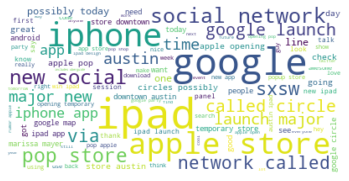

In [88]:
generate_WordCloud(df["Tweet_Word_tokens"],"Tweet_word_tokens.png")

# GENERATE WORD CLOUD OF NOUNS

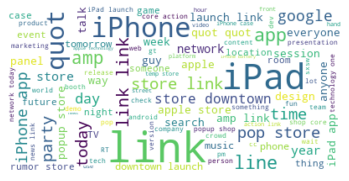

In [89]:
generate_WordCloud(df["Nouns"],"Tweet_nouns.png")

# check correlation between tweet length and sentiment, if any

In [90]:
df['sentiment'].corr(df['Tweet_len'])

0.0071789551812535615

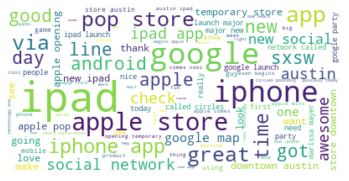

In [117]:
generate_WordCloud(df[df["sentiment"]==2]['Tweet_Word_tokens'],"Positive_senti.png")

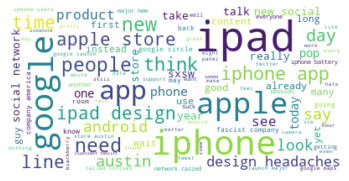

In [118]:
generate_WordCloud(df[df["sentiment"]==0]['Tweet_Word_tokens'],"Negative_senti.png")

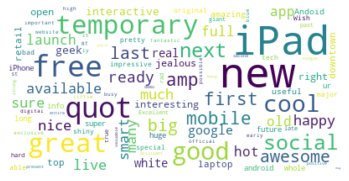

In [122]:
df_1 = df.copy()
df_1['Adjective'] = df_1['Tweet_basic_cleaned'].apply(lambda x: get_AdjList(x))
generate_WordCloud(df_1[df_1["sentiment"]==2]['Adjective'],"Positive_senti.png")

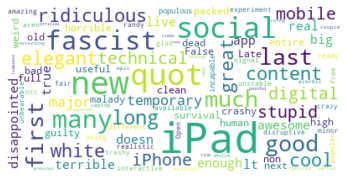

In [123]:
generate_WordCloud(df_1[df_1["sentiment"]==0]['Adjective'],"Negative_senti.png")

# GENERATING THE MODEL WITH COUNT VECTORIZER BAG OF WORDS + LOG REG

In [91]:
training_data, testing_data = train_test_split(df,test_size=0.3,random_state=7)

Y_train=training_data['sentiment'].values
Y_test=testing_data['sentiment'].values

X_train,X_test,feature_transformer=extract_features("Tweet_Word_tokens","CV")

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
df2=pd.DataFrame(X_train)
#print(df2.shape)
df3=pd.DataFrame(X_test)
#print(df3)
model=scikit_log_reg.fit(X_train,Y_train)
Y_pred = scikit_log_reg.predict(X_test)

pd.DataFrame(data={'predictions': Y_pred, 'actual': Y_test}).head(15)

Extracting features using :  CV
Field is :  Tweet_Word_tokens
training data size :  (5091, 15)
testing data size :  (2182, 15)
[LibLinear]

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


,predictions,actual
0,1,1
1,1,0
2,1,2
3,1,1
4,1,1
5,2,2
6,1,0
7,2,2
8,1,3
9,2,1


In [94]:
preds=get_top_k_predictions(model,X_test,3)
eval_items=collect_preds(Y_test,preds)
accuracy=compute_accuracy(eval_items)
mrr_at_k=compute_mrr_at_k(eval_items)
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
def_accuracy=metrics.accuracy_score(Y_test, Y_pred)
f1_score=metrics.f1_score(Y_test, Y_pred, average='weighted')

In [95]:
print("Y_pred = ",len(Y_pred))
#print(len(eval_items))
print(cnf_matrix)
print("\nAccuracy= ",def_accuracy)
print ("F1 Score = ",f1_score)

Y_pred =  2182
[[  32   81   36    1]
 [  20 1059  219    5]
 [   5  343  352    1]
 [   1   20    7    0]]

Accuracy=  0.6613198900091659
F1 Score =  0.6438867768920887


In [96]:
test_features=feature_transformer.transform(["good good great great nice super Music &gt; iPhone nerds RT @mention my god, cute girls everywhere...I love when interactive ends and music begins #sxsw"])
get_top_k_predictions(model,test_features,2)

[[2, 3]]

In [97]:
print ("Classification Report for LogisticRegression")
print(classification_report(Y_test,Y_pred))

Classification Report for LogisticRegression
              precision    recall  f1-score   support

           0       0.55      0.21      0.31       150
           1       0.70      0.81      0.75      1303
           2       0.57      0.50      0.54       701
           3       0.00      0.00      0.00        28

    accuracy                           0.66      2182
   macro avg       0.46      0.38      0.40      2182
weighted avg       0.64      0.66      0.64      2182



In [102]:
#ROC AUC score is not supported for multiclass format hence defining a fucntion to get average score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

print ("ROC AUC Score for LogisticRegression")
print (multiclass_roc_auc_score(Y_test, Y_pred))

ROC AUC Score for LogisticRegression
0.6037676215565576


# GENERATING THE MODEL WITH TFIDF VECTORIZER + LOG REG

In [103]:
training_data, testing_data = train_test_split(df,test_size=0.3,random_state=7)

Y_train=training_data['sentiment'].values
Y_test=testing_data['sentiment'].values

X_train,X_test,feature_transformer=extract_features("Tweet_Word_tokens","TFIDF")

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
model=scikit_log_reg.fit(X_train,Y_train)
#print(X_test)
df1=pd.DataFrame(X_test)
print(df1.shape)
Y_pred = scikit_log_reg.predict(X_test)
pd.DataFrame(data={'predictions': Y_pred, 'actual': Y_test}).head(15)

Extracting features using :  TFIDF
Field is :  Tweet_Word_tokens
training data size :  (5091, 15)
testing data size :  (2182, 15)
[LibLinear]

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


(2182, 1)


,predictions,actual
0,1,1
1,1,0
2,1,2
3,1,1
4,1,1
5,2,2
6,1,0
7,2,2
8,1,3
9,2,1


In [104]:
preds=get_top_k_predictions(model,X_test,3)
eval_items=collect_preds(Y_test,preds)
accuracy=compute_accuracy(eval_items)
mrr_at_k=compute_mrr_at_k(eval_items)
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
def_accuracy=metrics.accuracy_score(Y_test, Y_pred)
f1_score=metrics.f1_score(Y_test, Y_pred, average='weighted')

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
#print(preds)
#print(len(eval_items))
print(cnf_matrix)
print("\nAccuracy= ",def_accuracy)
print ("F1 Score = ",f1_score)

[[  27   89   34    0]
 [   8 1089  206    0]
 [   1  366  334    0]
 [   0   21    7    0]]

Accuracy=  0.6645279560036663
F1 Score =  0.6408472841633682


In [106]:
test_features=feature_transformer.transform(["Well yeah.  Music &gt; iPhone nerds RT @mention my god, cute girls everywhere...I love when interactive ends and music begins #sxsw"])
get_top_k_predictions(model,test_features,3)

[[2, 1, 0]]

In [107]:
print ("Classification Report for LogisticRegression with TFID")
print (classification_report(Y_test,Y_pred))

Classification Report for LogisticRegression with TFID
              precision    recall  f1-score   support

           0       0.75      0.18      0.29       150
           1       0.70      0.84      0.76      1303
           2       0.57      0.48      0.52       701
           3       0.00      0.00      0.00        28

    accuracy                           0.66      2182
   macro avg       0.51      0.37      0.39      2182
weighted avg       0.65      0.66      0.64      2182



/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [108]:
print ("ROC AUC Score for LogisticRegression with TFID")
print (multiclass_roc_auc_score(Y_test, Y_pred))

ROC AUC Score for LogisticRegression with TFID
0.5974366278198664


# NOW CLEAN TEST FILE AND RUN THE MODEL ON TEST DATA

In [109]:
dftest= pd.read_csv("test.csv")
dftest.isnull().sum()
dftest.shape

(1819, 2)

In [110]:
dftest['Hashtags'] = dftest['tweet'].apply(lambda x: hashtag_extract(x))
dftest['Tweet_basic_cleaned'] = dftest['tweet'].apply(lambda x: basic_cleanup(x))
dftest['Tweet_Word_tokens']=dftest['Tweet_basic_cleaned'].apply(lambda x: do_smart_word_tokenize(x))
dftest['Tweet_len']=dftest['Tweet_Word_tokens'].apply(lambda x: getTweetLength(x))
dftest['Lemmas']=dftest['Tweet_Word_tokens'].apply(lambda x: get_lemma_words(x))
dftest['Polarity']=dftest['Tweet_basic_cleaned'].apply(lambda x: get_Polarity(x))
dftest['Subjectivity']=dftest['Tweet_basic_cleaned'].apply(lambda x: get_Subjectivity(x))
dftest['Nouns']=dftest['Tweet_basic_cleaned'].apply(lambda x: get_NounList(x))
dftest['NounPhrases']=dftest['Tweet_basic_cleaned'].apply(lambda x: get_NounPhrases(x))
dftest['Bigrams']=dftest['Tweet_basic_cleaned'].apply(lambda x: get_bigrams(x))
dftest['Trigrams']=dftest['Tweet_basic_cleaned'].apply(lambda x: get_trigrams(x))
dftest['Userhandles'] = dftest['tweet'].apply(lambda x: user_extract(x))

dftest.head(20)

,tweet_id,tweet,Hashtags,Tweet_basic_cleaned,Tweet_Word_tokens,Tweet_len,Lemmas,Polarity,Subjectivity,Nouns,NounPhrases,Bigrams,Trigrams,Userhandles
0,7506,Audience Q: What prototyping tools do you use?...,"[#myprototype, #sxsw]",Audience Q What prototyping tools do you use ...,audience prototyping tools use sketchbooks sha...,97,audience prototyping tools use sketchbooks sha...,0.000000,0.000000,prototyping sharpie docs etc,"[audience q, sketchbooks, sharpie pens photosh...","[[Audience, Q], [Q, What], [What, prototyping]...","[[Audience, Q, What], [Q, What, prototyping], ...",[]
1,7992,At SXSW? Send Your Best Photos &amp; Videos to...,"[#citizen_journalism, #cnn, #ireport, #photogr...",At SXSW Send Your Best Photos amp Videos to...,sxsw send best photos videos journalism,39,sxsw send best photos videos journalism,1.000000,0.300000,Photos amp journalism,"[sxsw, your, photos, videos, link journalism]","[[At, SXSW], [SXSW, Send], [Send, Your], [Your...","[[At, SXSW, Send], [SXSW, Send, Your], [Send, ...",[]
2,247,@mention and here's a pic of you winning your...,"[#unsix, #sxsw]",and here s a pic of you winning your ipad ...,pic winning ipad cont,21,pic winning ipad cont,0.500000,0.750000,pic ipad cc cont link,[ipad cc link cont link],"[[and, here], [here, s], [s, a], [a, pic], [pi...","[[and, here, s], [here, s, a], [s, a, pic], [a...","[@mention, @mention, @mention]"
3,7688,Google Marissa Mayer: mobile phone as a cursor...,[#sxsw],Google Marissa Mayer mobile phone as a cursor...,google marissa mayer mobile phone cursor physi...,94,google marissa mayer mobile phone cursor physi...,0.207273,0.399481,phone cursor location version map fast life,"[google marissa mayer, mobile phone, physical ...","[[Google, Marissa], [Marissa, Mayer], [Mayer, ...","[[Google, Marissa, Mayer], [Marissa, Mayer, mo...",[]
4,3294,#SXSW Google maps is even cooler than I thought,[#SXSW],Google maps is even cooler than I thought,google maps even cooler thought,31,google maps even cooler thought,0.000000,0.000000,,[google],"[[Google, maps], [maps, is], [is, even], [even...","[[Google, maps, is], [maps, is, even], [is, ev...",[]
5,6125,RT @mention In front of @mention popup store a...,[#SXSW],RT In front of popup store at last night l...,front popup store last night,28,front popup store last night,0.000000,0.066667,front store night link,"[rt, popup store, night link]","[[RT, In], [In, front], [front, of], [of, popu...","[[RT, In, front], [In, front, of], [front, of,...","[@mention, @mention]"
6,6131,RT @mention In my next life I'm coming back as...,[#SXSW],RT In my next life I m coming back as an iPad...,next life coming back ipad women keep hands thing,49,next life coming back ipad women keep hands thing,0.000000,0.000000,RT life thing,[rt],"[[RT, In], [In, my], [my, next], [next, life],...","[[RT, In, my], [In, my, next], [my, next, life...",[@mention]
7,4134,Google celebrating Pi Day in style at #SXSW - ...,[#SXSW],Google celebrating Pi Day in style at link,google celebrating day style,28,google celebrating day style,0.000000,0.000000,style link,"[google, pi day]","[[Google, celebrating], [celebrating, Pi], [Pi...","[[Google, celebrating, Pi], [celebrating, Pi, ...",[]
8,8206,Hmmm is it a bit weird that #sxsw is not tendi...,[#sxsw],Hmmm is it a bit weird that is not tending bu...,hmmm bit weird tending google circle,36,hmmm bit weird tending google circle,-0.500000,1.000000,bit,"[hmmm, bit weird, google]","[[Hmmm, is], [is, it], [it, a], [a, bit], [bit...","[[Hmmm, is, it], [is, it, a], [it, a, bit], [a...",[]
9,8552,@mention to launch 'Circles' later today at #S...,"[#SXSW??, #SXSW]",to launch Circles later today at gotta l...,launch circles later today got love one platfo...,92,launch circles later today got love one platfo...,0.250000,0.431250,today platform everything film,"[circles, independent film, innovative tech]","[[to, launch], [launch, Circles], [Circles, la...","[[to, launch, Circles], [launch, Circles, late...",[@mention]


In [111]:
print(df.shape)
print(dftest.shape)

(7273, 15)
(1819, 14)


# model generation and testing

In [115]:

training_data, testing_data = train_test_split(df,random_state = 2000)

Y_train=training_data['sentiment'].values
Y_test=testing_data['sentiment'].values

cv3= CountVectorizer(binary=False, max_df=0.95)
cv3.fit_transform(df['Tweet_Word_tokens'].values)

X_train=cv3.transform(training_data['Tweet_Word_tokens'].values)
X_test=cv3.transform(testing_data['Tweet_Word_tokens'].values)    

scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
df5=pd.DataFrame(X_train)
print("X train \n",df5.shape)
df6=pd.DataFrame(X_test)
print("x test \n", df6.shape)
model=scikit_log_reg.fit(X_train,Y_train)
Y_pred = scikit_log_reg.predict(X_test)


# now work on test file

#cv2= CountVectorizer(binary=False, max_df=0.95)
#cv3.fit_transform(dftest['Tweet_Word_tokens'].values)

#train_feature_set=cv.transform(training_data[field].values)
X_test_2=cv3.transform(dftest['Tweet_Word_tokens'].values) 

df7=pd.DataFrame(X_test_2)
#print(" X test 2\n", df7.head(10))

Y_pred_2 = scikit_log_reg.predict(X_test_2)

test_tweet_ids=dftest['tweet_id']
(pd.DataFrame(data={ 'tweet_id': test_tweet_ids, 'sentiment': Y_pred_2})).reset_index().to_csv('sample_submission.csv')

X train 
 (5454, 1)
x test 
 (1819, 1)
[LibLinear]

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
